# Fitting STSynPhot Models to Data
This code generates models based off of given parameters (effective temperature, surface gravity, radial velocity, reddening, radius). The goal is to replicate my sample of yellow supergiants (YSGs) using the package stsynphot.

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import stsynphot as stsyn
import matplotlib.pyplot as plt
import numpy as np
from astropy.io.fits import getheader
from astropy.io import fits
import numpy as np
import astropy.units as u
from matplotlib import pyplot as plt
from astropy.io.fits import getheader
from specutils import Spectrum1D
from glob import glob
from termcolor import colored   
from specutils.manipulation import box_smooth
from specutils.manipulation import LinearInterpolatedResampler
import emcee
import corner
from tqdm import tqdm

In [2]:
#grab anything that contains '.fits'
files = glob('*.fits')
print(files)

['hd269879_122722.fits', 'hd269857_122722.fits', 'hd27005_122722.fits', 'hd269723_122722.fits', 'hd269662_122622.fits', 'hd269070_122622.fits', 'sk_69_99_122622.fits', 'hd269697_122722.fits', 'hd269902_122722.fits', 'w60_d17_122622.fits', 'hd269331_122622.fits', 'hd269661_122622.fits', 'hd268727_010323.fits', 'hd269762_122722.fits', 'hd269953_122722.fits', 'hd33579_122622.fits', 'hv2450_122622.fits', 'hv883_010323.fits', 'hd269604_122622.fits', 'hd268819_122622.fits', 'j05344_122722.fits', 'cd_69_310_122622.fits', 'sp77_31_16_122622.fits', 'cpd-69-496_122722.fits', 'hd269781_122722.fits', 'hd268687_122622.fits', 'sp77_48_6_122622.fits', 'hd268828_010323.fits', 'hd269651_122622.fits', 'hd269982_122722.fits', 'sk_69_148_122622.fits', 'hd268949_010323.fits', 'hd268946_122622.fits', 'hd269840_122722.fits', 'rm177_010323.fits', 'hd269110_122622.fits', 'hd269787_122722.fits', 'hd269807_122722.fits', 'hd268971_122622.fits', 'hd268865_010323.fits']


# Define Preliminary Functions
First, we can define functions that will generate graphs of the data, smoothed data, and stsynphot model so we can use them in more specific functions that will combine the use of them and plot them on one graph.

In [3]:
def ssp(theta):
    """
    Generates a stsynphot graph based on theta values where theta = [t_eff, log_g, rv, ebv, radius]. 
    The bounds are: (4000 <= t_eff <= 12500) & (-.5<=log_g<=3) & (-100<=rv<=100) & (0<=ebv<=2.5) & (1<=radius<=1000).
    """
    t_eff, log_g, rv, ebv, radius = theta # unpack theta
    model = stsyn.grid_to_spec('ck04models', t_eff, -0.25, log_g) # model from Castelli & Kurucz (2004)
    model.z = rv/(299792458/1000) # speed of light converted from m/s to km/s
    
    reddening = stsyn.spectrum.ebmvx('lmcavg', ebv) # average of total/selective dimming
    
    reddenedmodel = reddening*model
    
    reddenedmodel_flux = reddenedmodel(wavelength, flux_unit='flam')
    
    reddenedmodel_flux*=(radius/(2.15134e12))**2
    
    return reddenedmodel_flux

In [4]:
def fitsfile(i):
    """
    Opens fits file and prints which file it is
    """
    hdulist = fits.open(str(files[i]))
    hdr = getheader(files[i])
    spec1d = Spectrum1D.read("/Users/kchen/FYPS/"+ files[i])
    filename = '/Users/kchen/FYPS/' + files[i]
# The spectrum is in the first HDU of this file.
    with fits.open(filename) as f:  
        specdata = f[0].data
    text = colored('----------------\nThis graph is: ' + files[i] + ' and array ' + str(i), 'red', attrs=['bold'])  
    #print(text)  
    #print(specdata)
    
    #print(spec1d)
    return spec1d
    

In [5]:
def smooth(i):
    """
    Smooths the data for graph i so that it is easier to see the continuum and match the model to the data.
    """
    spec1d = fitsfile(i)
    spec_smooth = box_smooth(spec1d, width=1500)
    wavelength_grid = np.arange(spec1d.spectral_axis.value.min(), spec1d.spectral_axis.value.max(), 20) * u.AA
    linear = LinearInterpolatedResampler()
    spec_interp = linear(spec_smooth, wavelength_grid)
    print(spec_smooth)
    return spec_interp, spec1d

In [6]:
def byeye(theta, wavelength, i):
    """
    Takes effective temperature, surface gravity, radial velocity, reddening, and radius (in solar radii)
    and an array of wavelength points and 
    outputs corresponding model flux evaluated on the wavelength array
    """

    reddenedmodel_flux = ssp(theta) # constructs stsynphot model based on theta
    spec_interp, spec1d = smooth(i)
    
    
    ax = plt.subplots()[1] 
    ax.plot(spec_interp.spectral_axis.value, spec_interp.flux.value)
    ax.set_xlim(3000,9700)
    #ax.set_ylim(0,2e-13)
    ax.set_ylabel('Flux (erg/s/cm^2/Å)', fontsize = 15)
    ax.set_xlabel('Wavelength (Å)', fontsize = 15)
    plt.plot(wavelength, reddenedmodel_flux)
    plt.show
    diff=np.diff(spec1d.spectral_axis.value) #find resolution diff
    print(diff)

In [7]:
# wavelength = np.linspace(3500, 9500, 20000) # wavelength grid of 20k points
# model = stsyn.grid_to_spec('ck04models', 6300, -0.25, 0.5) #model from Castelli & Kurucz (2004)

# model_flux = model(wavelength, flux_unit='flam') #flux units are silly...

# plt.plot(wavelength, model_flux)
# #plt.close()

In [8]:
def fit(t_eff, log_g, rv, ebv, radius, wavelength, i):
    """
    Takes effective temperature, surface gravity, radial velocity, reddening, and radius (in solar radii)--emitted vs observed Flux fobs=fsurface(R/d)^2, multiply reddening by (r/d)^2. R in solar radii. d=158200 lightyear 
    and an array of wavelength points and 
    outputs corresponding model flux evaluated on the wavelength array
    """

    reddenedmodel_flux = ssp(theta) # constructs stsynphot model based on theta
    spec1d = fitsfile(i)
    
    ax = plt.subplots()[1] 
    ax.plot(spec1d.spectral_axis.value, spec1d.flux.value)
    ax.set_xlim(3000,9700)
    #ax.set_ylim(0,2e-13)
    ax.set_ylabel('Flux (erg/s/cm^2/Å)', fontsize=15)
    ax.set_xlabel('Wavelength (Å)', fontsize=15)
    plt.plot(wavelength, reddenedmodel_flux)
    plt.show
    diff=np.diff(spec1d.spectral_axis.value) #find resolution diff
    print(diff)

In [9]:
#1, actual teff: 7400
wavelength = np.linspace(3000, 9700, 20000) # wavelength grid 
#fit(6350, 1.2, 0, .01, 300, wavelength, 1)
fit(6500, .5, 0, .05, 300, wavelength, 1) #guess
fit(7400, .5, 0, .225, 300, wavelength, 1) #using known value

NameError: name 'theta' is not defined

In [ ]:
#9, actual teff: 4440
wavelength = np.linspace(3000, 9700, 20000) # wavelength grid 

#fit(6000, 2, 0, .6, 490, wavelength, 9)
fit(4590, 2, 0, .1, 500, wavelength, 9)
fit(4440, 2, 0, .1, 500, wavelength, 9) #actual

In [ ]:
#3, actual teff:5930
fit(9950, 2.5, 0, .69, 500, wavelength, 3)
fit(5930, 2.5, 0, .25, 640, wavelength, 3) #actual

In [10]:
def hilowres(i):#t_eff, log_g, rv, ebv, radius, wavelength, i):
    """
    Takes effective temperature, surface gravity, radial velocity, reddening, and radius (in solar radii)--emitted vs observed Flux fobs=fsurface(R/d)^2, multiply reddening by (r/d)^2. R in solar radii. d=158200 lightyear 
    and an array of wavelength points and 
    outputs corresponding model flux evaluated on the wavelength array
    """

    spec_interp, spec1d = smooth(i)
    print(spec1d)
    
    ax = plt.subplots(dpi=300)[1]
    ax.plot(spec1d.spectral_axis.value, spec1d.flux.value, alpha = .4)
    ax.plot(spec_interp.spectral_axis.value, spec_interp.flux.value)

    ax.set_xlim(3000,9700)
    #ax.set_ylim(0,2e-13)
    ax.set_ylabel('Flux (erg/s/cm^2/Å)', fontsize=15)
    ax.set_xlabel('Wavelength (Å)', fontsize=15)
    #plt.plot(wavelength, reddenedmodel_flux)
    plt.show
    diff=np.diff(spec1d.spectral_axis.value) #find resolution diff
    print(diff)


Spectrum1D (length=192772)
flux:             [ 1.1e-13 erg / (A cm2 s), ..., 1.0205e-14 erg / (A cm2 s) ],  mean=8.2405e-14 erg / (A cm2 s)
spectral axis:    [ 3323.2 Angstrom, ..., 9667.5 Angstrom ],  mean=6495.4 Angstrom
Spectrum1D (length=192772)
flux:             [ 0.0 erg / (A cm2 s), ..., 2.3169e-14 erg / (A cm2 s) ],  mean=8.2642e-14 erg / (A cm2 s)
spectral axis:    [ 3323.2 Angstrom, ..., 9667.5 Angstrom ],  mean=6495.4 Angstrom
[0.03291083 0.03291083 0.03291083 ... 0.03291083 0.03291083 0.03291083]


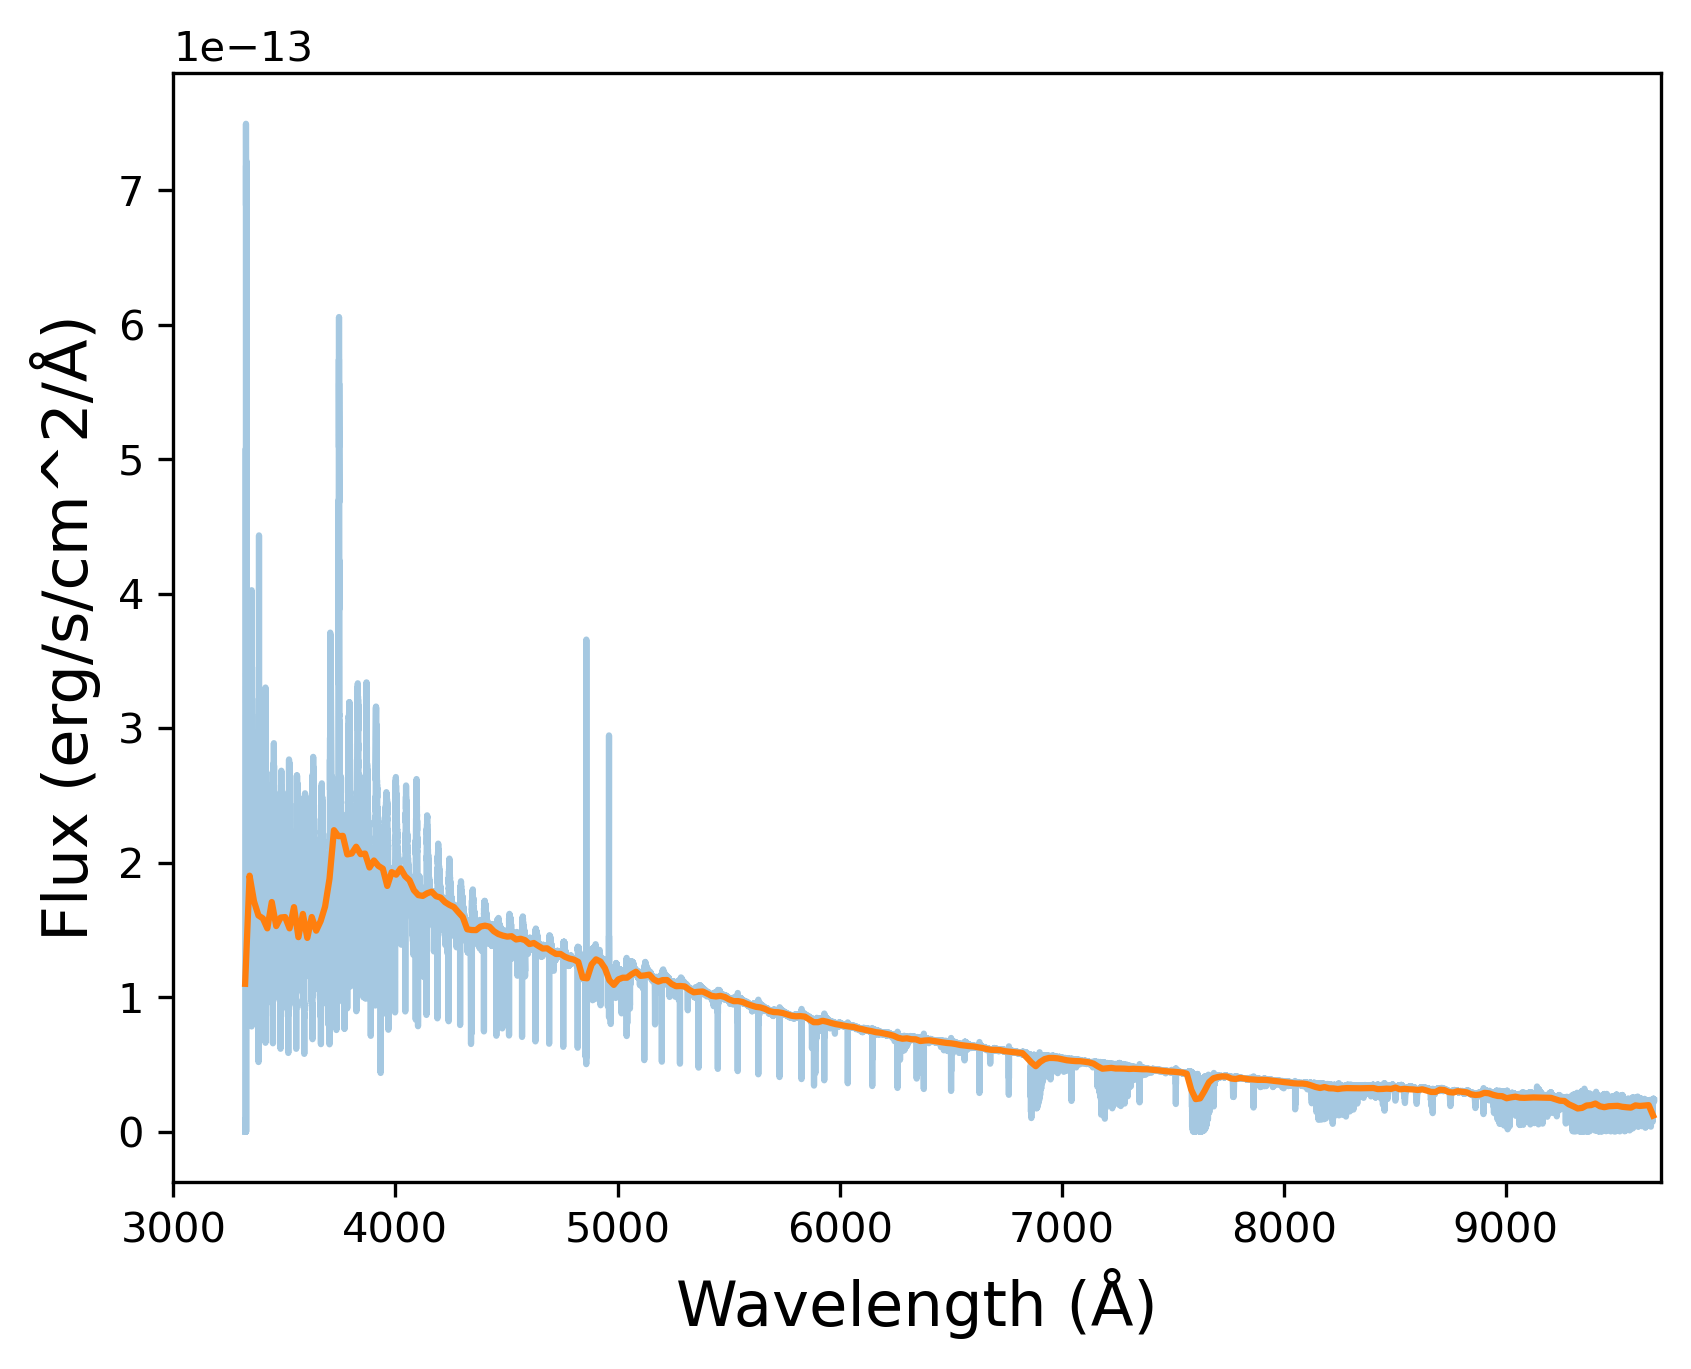

In [11]:
hilowres(13)

In [ ]:
smooth(7400, 2, 0, .243, 304, wavelength, 1)

TypeError: lowres() takes 1 positional argument but 7 were given

In [ ]:
def all(theta, wavelength, t_eff1, log_g1, rv1, ebv1, radius1, i):
    """
    Takes accurate effective temperature, surface gravity, radial velocity, reddening, and radius
    and an array of wavelength points and the the guess teff etc and 
    outputs corresponding model flux evaluated on the wavelength array
    """

    reddenedmodel_flux = ssp(theta) # constructs stsynphot model based on theta
    spec_interp, spec1d = smooth(i)

    #wrong teff
    model1 = stsyn.grid_to_spec('ck04models', t_eff1, -0.25, log_g1) #model from Castelli & Kurucz (2004)
    model1.z = rv1/(299792458/1000) #speed of light converted from m/s to km/s
    
    reddening1 = stsyn.spectrum.ebmvx('lmcavg', ebv1) #average of total/selective dimming
    
    
    reddenedmodel1 = reddening1*model1
    
    reddenedmodel_flux1 = reddenedmodel1(wavelength, flux_unit='flam')
    
    reddenedmodel_flux1*=(radius1/(2.15134e12))**2
    
    
    
    hdulist = fits.open(str(files[i]))
    hdr = getheader(files[i])
    spec1d = Spectrum1D.read("/Users/kchen/FYPS/"+ files[i])
    filename = '/Users/kchen/FYPS/' + files[i]
# The spectrum is in the first HDU of this file.
    with fits.open(filename) as f:  
        specdata = f[0].data
    text = colored('----------------\nThis graph is: ' + files[i] + ' and array ' + str(i), 'red', attrs=['bold'])  
    print(text)  
    print(specdata)
    
    print(spec1d)
    
    # smooth
    spec_smooth = box_smooth(spec1d, width=1500)
    wavelength_grid = np.arange(spec1d.spectral_axis.value.min(), spec1d.spectral_axis.value.max(), 20) * u.AA
    linear = LinearInterpolatedResampler()
    spec_interp = linear(spec_smooth, wavelength_grid)
    
    
    ax = plt.subplots(dpi=300)[1] 
    #ax.plot(spec1d.spectral_axis.value, spec1d.flux.value, alpha=.3, label= 'original data')
    ax.plot(spec_interp.spectral_axis.value, spec_interp.flux.value, label='smoothed data', lw=2)
    ax.set_xlim(3000,9700)
    #ax.set_ylim(0,2e-13)
    ax.set_ylabel('Flux (erg/s/cm^2/Å)', fontsize = 15)
    ax.set_xlabel('Wavelength (Å)', fontsize = 15)
    plt.plot(wavelength, reddenedmodel_flux1, label='by-eye model', alpha=.8)
    plt.plot(wavelength, reddenedmodel_flux, label='SIMBAD temperature')
    
    
    
    plt.show
    diff=np.diff(spec1d.spectral_axis.value) #find resolution diff
    print(diff)
    ax.legend(loc='upper right')


----------------
This graph is: hd269857_122722.fits and array 1
[0.000000e+00 0.000000e+00 0.000000e+00 ... 9.164395e-14 9.208172e-14
 9.241548e-14]
Spectrum1D (length=192788)
flux:             [ 0.0 erg / (A cm2 s), ..., 9.2415e-14 erg / (A cm2 s) ],  mean=1.829e-13 erg / (A cm2 s)
spectral axis:    [ 3323.7 Angstrom, ..., 9668.3 Angstrom ],  mean=6496.0 Angstrom


----------------
This graph is: hd269857_122722.fits and array 1
[0.000000e+00 0.000000e+00 0.000000e+00 ... 9.164395e-14 9.208172e-14
 9.241548e-14]
Spectrum1D (length=192788)
flux:             [ 0.0 erg / (A cm2 s), ..., 9.2415e-14 erg / (A cm2 s) ],  mean=1.829e-13 erg / (A cm2 s)
spectral axis:    [ 3323.7 Angstrom, ..., 9668.3 Angstrom ],  mean=6496.0 Angstrom
[0.03290965 0.03290965 0.03290965 ... 0.03290965 0.03290965 0.03290965]


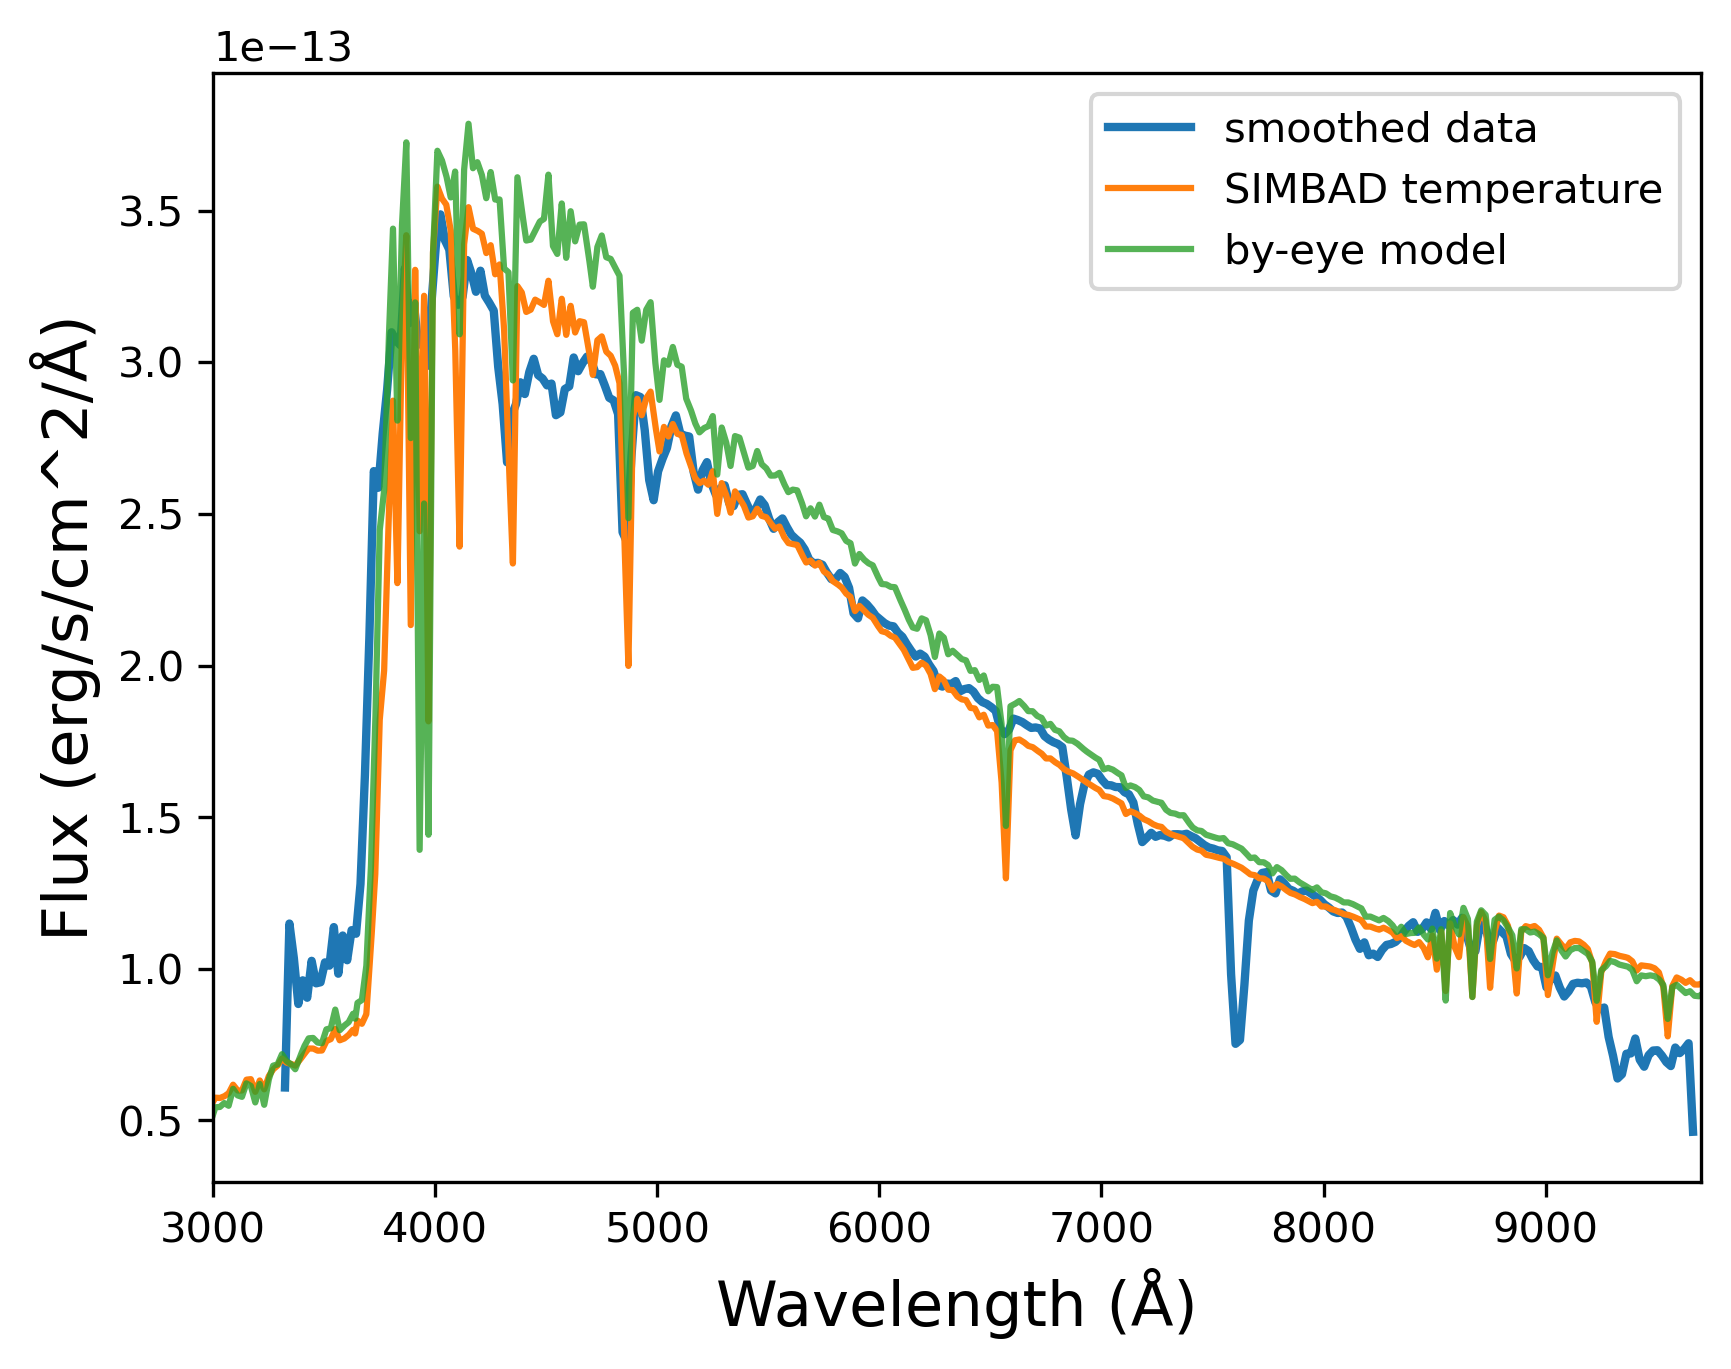

In [ ]:
theta = (7400, 2, 0, .243, 304)
#(9950, 2.5, 0, .69, 500, wavelength, 3)
all(theta, wavelength, 6500, .5, 0, .05, 300, 1)

----------------
This graph is: hd269723_122722.fits and array 3
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.4722759e-13 2.4533766e-13
 2.4406060e-13]
Spectrum1D (length=192769)
flux:             [ 0.0 erg / (A cm2 s), ..., 2.4406e-13 erg / (A cm2 s) ],  mean=2.7851e-13 erg / (A cm2 s)
spectral axis:    [ 3322.9 Angstrom, ..., 9666.1 Angstrom ],  mean=6494.5 Angstrom


----------------
This graph is: hd269723_122722.fits and array 3
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.4722759e-13 2.4533766e-13
 2.4406060e-13]
Spectrum1D (length=192769)
flux:             [ 0.0 erg / (A cm2 s), ..., 2.4406e-13 erg / (A cm2 s) ],  mean=2.7851e-13 erg / (A cm2 s)
spectral axis:    [ 3322.9 Angstrom, ..., 9666.1 Angstrom ],  mean=6494.5 Angstrom
[0.03290576 0.03290576 0.03290576 ... 0.03290576 0.03290576 0.03290576]


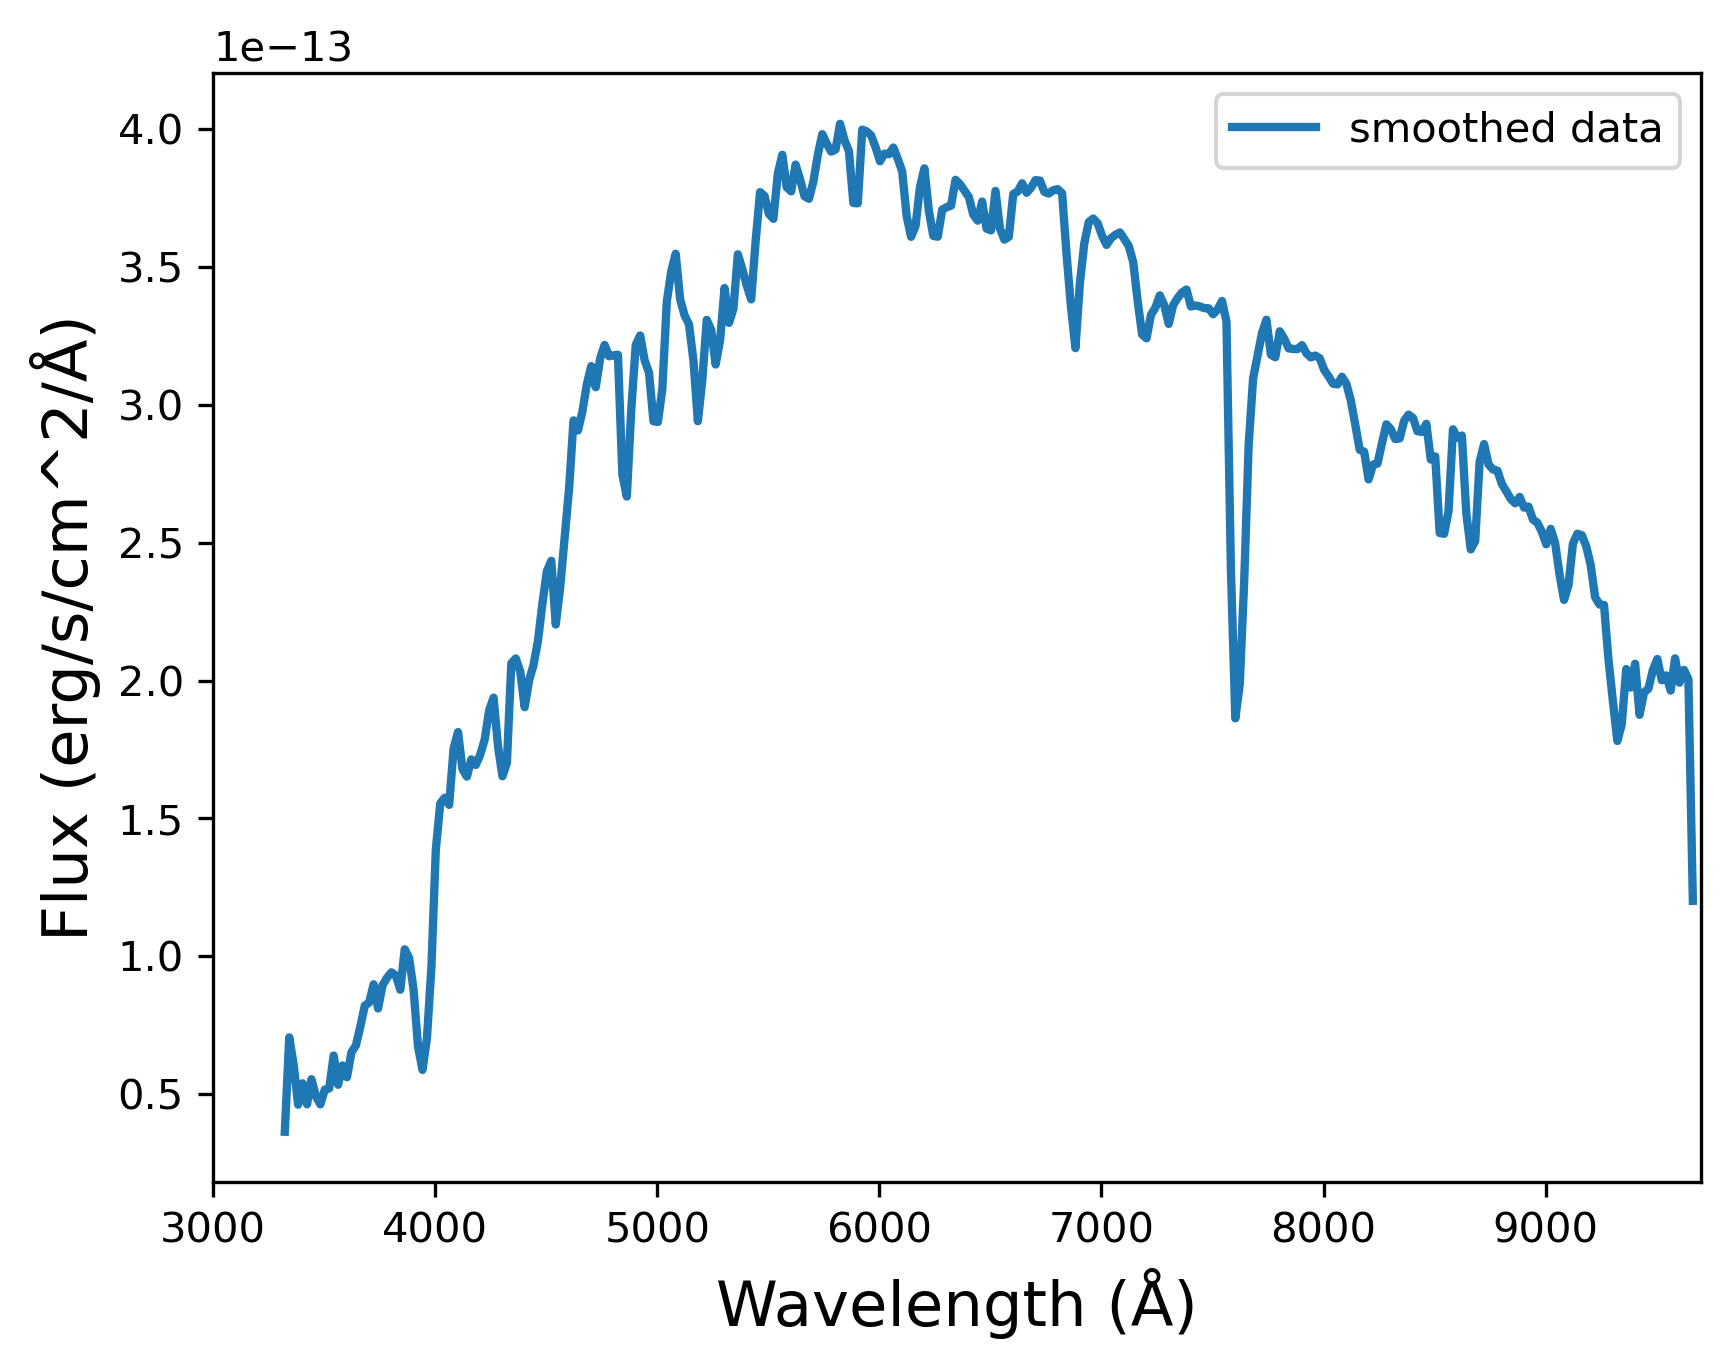

In [ ]:
#(9950, 2.5, 0, .69, 500, wavelength, 3)
theta=(5930, 2.5, 0, .4, 750)
all(theta, wavelength, 9950, 2.5, 0, .69, 500, 3)